# Copyright Netherlands eScience Center <br>
** Function     : Predict the extent of Sea Ice Concentration with LSTM ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.17 ** <br>
** Last Update  : 2019.05.01 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, deepclim, matplotlib
Description     : This notebook serves to predict the Arctic sea ice using deep learning. As a pre-test, we start with time series of SIC extent anomalies. To make it easier, we use many climate index (to represent the forcing from atmosphere). In addtion,  <br>

The Long Short Time Memory neural network is used here. We use Pytorch as the deep learning framework. <br>

Return Values   : Time series and figures <br>

Here is the information of climate index in details:<br>
**NAO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/nao.shtml <br>
**ENSO - NINO 3.4 SST** @ 1950 Jan - 2018 Jan (817 records) <br>
https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/Nino34/ <br>
**AO** @ 1950 Jan - 2018 Feb (818 records) <br>
http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/ao.shtml <br>
**AMO** @ 1950 Jan - 2018 Feb (818 records) <br>
AMO unsmoothed, detrended from the Kaplan SST V2. The result is standarised.<br>
https://www.esrl.noaa.gov/psd/data/timeseries/AMO/<br>

(All the NOAA index shown above are given by NCEP/NCAR Reanalysis (CDAS))<br>

**PDO** @ 1900 Jan - 2018 Feb (1418 records)<br>
This PDO index comes from University of Washington, it contains SST data from the following 3 datasets:<br>
- UKMO Historical SST data set for 1900-81;
- Reynold's Optimally Interpolated SST (V1) for January 1982-Dec 2001)
- OI SST Version 2 (V2) beginning January 2002 -<br>

http://research.jisao.washington.edu/pdo/PDO.latest<br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/Scripts/DeepClim")
# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional
import deepclim
import deepclim.preprocess
import deepclim.deepSeries
#import deepclim.function

# for visualization
import deepclim.visual
import matplotlib
import matplotlib.pyplot as plt
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2016 (ECMWF)
- **ORAS4**       1958 - 2014 (ECMWF)

** Index ** <br>
- **NINO3.4**     1950 - 2017 (NOAA)
- **AO**          1950 - 2017 (NOAA)
- **NAO**         1950 - 2017 (NOAA)
- **AMO**         1950 - 2017 (NOAA)
- **PDO**         1950 - 2017 (University of Washington)

!! These index are given by NCEP/NCAR Reanalysis (CDAS) <br>


Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [3]:
################################   path  ######################################
# please specify data path
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
datapath_PIOMASS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
datapath_clim_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/Series'

In [4]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))

    dataset_PIOMASS_siv = Dataset(os.path.join(datapath_PIOMASS,
                                       'siv_monthly_PIOMASS_1979_2017.nc'))
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath_ORAS4,
                                             'oras_model_monthly_1958_2017_ohc.nc'))
    dataset_index = Dataset(os.path.join(datapath_clim_index,
                                         'index_climate_monthly_regress_1950_2017.nc'))
    #dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
    #                                  'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # mask
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    print ('*********************** extract variables *************************')
    # ********************************** data gallery *************************************** #
    # we use time series from 1979 to 2016 (468 months in total)
    # training data: 1979 - 2006
    # validation: 2007 - 2016
    # variables list:
    # SIC (ERA-Interim) / SIV (PIOMASS) / SST (ERA-Interim) / ST (ERA-Interim) / OHC (ORAS4) / AO-NAO-AMO-NINO3.4 (NOAA)
    # integrals from spatial fields cover the area from 20N - 90N (4D fields [year, month, lat, lon])
    # *************************************************************************************** #
    # SIC (ERA-Interim)
    SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:,:95,:] # 3D fields [time, lat, lon]
    #SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])
    time_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['time'][:]
    latitude_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]
    #SIV (PIOMASS)
    SIV_PIOMASS = dataset_PIOMASS_siv.variables['SIV'][:-12]
    year_SIV = dataset_PIOMASS_siv.variables['year'][:-1]
    # SST (ERA-Interim)
    SST_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['sst'][:,:95,:] # 3D fields [time, lat, lon]
    # dimensions the same as above
    # ST (ERA-Interim)
    # OHC (ORAS4)
    OHC_100_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_100_int'][21:-1,:,180:]/1000 # unit Peta Joule
    OHC_300_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_300_int'][21:-1,:,180:]/1000
    OHC_700_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_700_int'][21:-1,:,180:]/1000
    #OHC_2000_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_2000_int'][21:-1,:,180:]/1000
    
    latitude_OHC_ORAS4 = dataset_ORAS4_OHC.variables['latitude_aux'][180:]
    #gphiv_OHC_ORAS4 = dataset_ORAS4_OHC.variables['gphiv'][180:,:]
    #glamv_OHC_ORAS4 = dataset_ORAS4_OHC.variables['glamv'][180:,:]
    # AO-NAO-AMO-NINO3.4 (NOAA)
    AO = dataset_index.variables['AO'][348:-12] # from 1979 - 2016
    NAO = dataset_index.variables['NAO'][348:-12]
    NINO = dataset_index.variables['NINO'][348:-12]
    AMO = dataset_index.variables['AMO'][348:-12]
    PDO = dataset_index.variables['PDO'][348:-12]
    
    # radiation flux
    #rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:] # unit Watt/m2
    #rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:] # unit Watt/m2
    #rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:] # unit Watt/m2
    #rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:] # unit Watt/m2
    # turbulent flux
    #SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:] # unit Watt/m2
    #SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:] # unit Watt/m2

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [5]:
    print (latitude_ERAI[:41])
    print (latitude_OHC_ORAS4[53:])
    #print (SIC)

[90.   89.25 88.5  87.75 87.   86.25 85.5  84.75 84.   83.25 82.5  81.75
 81.   80.25 79.5  78.75 78.   77.25 76.5  75.75 75.   74.25 73.5  72.75
 72.   71.25 70.5  69.75 69.   68.25 67.5  66.75 66.   65.25 64.5  63.75
 63.   62.25 61.5  60.75 60.  ]
[60.018433 60.629475 61.236465 61.839542 62.43884  63.03449  63.626625
 64.21538  64.800865 65.38321  65.96254  66.538956 67.11257  67.683495
 68.251816 68.817635 69.38102  69.942055 70.50082  71.05734  71.6117
 72.163925 72.71404  73.26208  73.80803  74.3519   74.89367  75.43331
 75.97079  76.50603  77.03899  77.569565 78.09767  78.6232   79.146034
 79.66603  80.18305  80.69692  81.20748  81.71455  82.21792  82.71739
 83.21276  83.7038   84.19027  84.67194  85.14858  85.619934 86.08574
 86.545746 86.999664 87.44722  87.888054 88.32173  88.74752  89.16367
 89.562836 89.83964  89.562836]


In [5]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / len(latitude_ERAI)
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:95])):
        # change the unit to terawatt
        SIC_ERAI_area[:,i,:] = SIC_ERAI[:,i,:]* dx[i] * dy # unit m2
    
    print ('******************  calculate mean/sum from spatial fields  *******************')
    # calculate the mean SST in the polar cap
    SST_ERAI_mean = np.mean(np.mean(SST_ERAI[:,:41,:],2),1)
    # calculate the total OHC in the polar cap
    OHC_100_ORAS4_sum = np.sum(OHC_100_int_ORAS4[:,:,53:],2)
    OHC_300_ORAS4_sum = np.sum(OHC_300_int_ORAS4[:,:,53:],2)
    OHC_700_ORAS4_sum = np.sum(OHC_700_int_ORAS4[:,:,53:],2)
    # calculate the total SIC in the polar cap
    SIC_ERAI_sum = np.sum(np.sum(SIC_ERAI_area[:,:41,:],2),1)

******************  calculate extent from spatial fields  *******************
******************  calculate mean/sum from spatial fields  *******************


In [6]:
    print ('*******************  pre-processing  *********************')
    print ('================  reshape input data into time series  =================')
    OHC_700_ORAS4_sum_series= deepclim.preprocess.operator.unfold(OHC_700_ORAS4_sum)
    print ('=========================   normalize data   ===========================')
    SIC_ERAI_sum_norm = deepclim.preprocess.operator.normalize(SIC_ERAI_sum)
    SIV_PIOMASS_norm = deepclim.preprocess.operator.normalize(SIV_PIOMASS)
    print ('====================    A series of time (index)    ====================')
    time_series = np.arange(0,len(SIC_ERAI_sum_norm),1)
    year = np.arange(1979,2017,1)
    year_cycle = np.repeat(year,12)
    month_cycle = np.tile(np.arange(1,13,1),len(time_series)//12)
    month_cycle.astype(float)
    #month_cycle = np.array(list(np.arange(1,13,1))*(len(time_index)//12),dtype=float)
    print ('===================  artificial data for evaluation ====================')
    # calculate climatology of SIC
    seansonal_cycle_SIC = np.zeros(12,dtype=float)
    for i in np.arange(12):
        seansonal_cycle_SIC[i] = np.mean(SIC_ERAI_sum_norm[i::12],axis=0)
    # weight for loss
    weight_month = np.array([0,1,1,
                             0,0,0,
                             0,1,1,
                             0,0,0])
    weight_loss = np.tile(weight_month,len(time_series)//12)

*******************  pre-processing  *********************
================  reshape input data into time series  =================
=========================   normalize data   ===========================
====================    A series of time (index)    ====================
===================  artificial data for evaluation ====================


In [7]:
    #print(seansonal_cycle_SIC[:])
    print(SIC_ERAI_sum_norm[12:24])
    #print(SIC_ERAI_sum_norm[13:25])
    print(year_cycle.shape)
    print (month_cycle[:12])
    print(weight_loss)

[0.91049867 0.95040081 0.95363012 0.938407   0.85274288 0.72234553
 0.50107235 0.31500285 0.33449173 0.5307878  0.71548149 0.87862723]
(456,)
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1
 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1
 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0
 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0
 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0
 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0
 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1
 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1
 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0
 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1

# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [8]:
    print ('*******************          prepare input tensor for LSTM           *********************')
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_size = 2
    hidden_size = 4
    batch_size = 1
    output_size = 1
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 4000
    print (torch.__version__)
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # standard LSTM input dimension
    # [sequence_length, batch_size, input_size]
    # example : x = torch.autograd.Variable(torch.randn(6, 3, 5))
    # prepare input array for LSTM input -> dimension
    # take 3 year as test data
    test_year = 3
    print ('******************* create input tensor with single-input dimension   *********************')
    SIC = SIC_ERAI_sum_norm[1:-test_year*12+1].reshape(len(SIC_ERAI_sum_norm[1:-test_year*12+1]),1,1)
    #SIV = SIV_PIOMASS_norm[:-test_year*12].reshape(len(SIV_PIOMASS_norm[:-test_year*12]),1,1)
    #time = time_series[:-test_year*12].reshape(len(time_series[:-test_year*12]),1,1)
    #year = year_cycle[:-test_year*12].reshape(len(year_cycle[:-test_year*12]),1,1)
    #month = month_cycle[:-test_year*12].reshape(len(month_cycle[:-test_year*12]),1,1)
    print ('*******************   create input tensor with multi-input dimension   *********************')
    # create variables
    x_input = np.vstack((SIC_ERAI_sum_norm[:-test_year*12],month_cycle[:-test_year*12])).T #hstack,dstack
    x_input = x_input.reshape(len(month_cycle[:-test_year*12]),1,input_size)
    print ('*******************   create tensors  *********************')
    SIC_var = torch.autograd.Variable(torch.Tensor(SIC))
    #SIV_var = torch.autograd.Variable(torch.Tensor(SIV))
    #time_var = torch.autograd.Variable(torch.Tensor(time))
    #month_var = torch.autograd.Variable(torch.Tensor(month))
    x_var = torch.autograd.Variable(torch.Tensor(x_input))
    weight_loss_var = torch.autograd.Variable(torch.Tensor(weight_loss[1:-test_year*12+1]))

*******************          prepare input tensor for LSTM           *********************
*******************  create basic dimensions for tensor and network  *********************
1.0.1.post2
Is CUDA available? False
******************* create input tensor with single-input dimension   *********************
*******************   create input tensor with multi-input dimension   *********************
*******************   create tensors  *********************


In [10]:
    print ('*******************  preview of input tensor  *********************')
    #plt.plot(SIC_ERAI_sum)
    print(x_var.shape)
    #plt.plot(SIC[:,0,0],label="SIC")
    #plt.plot(SIV[:,0,0],label="SIV")
    #plt.plot(x_input[:,0,1],label="month")
    #plt.legend()
    print(len(x_input))
    print(weight_loss_var.shape)

*******************  preview of input tensor  *********************
torch.Size([420, 1, 2])
420
torch.Size([420])


In [ ]:
#     print ('*******************  module for calculating accuracy  *********************')
#     def accuracy(out, labels):
#         outputs = np.argmax(out, axis=1)
#     return np.sum(outputs==labels)/float(labels.size)

In [11]:
    print ('*******************  run LSTM  *********************')
    # choose training data
    y_train = SIC_var
    # initialize our model
    model = deepclim.deepSeries.LSTM(input_size, hidden_size, batch_size=batch_size,
                                     output_dim=output_size, num_layers=num_layers)
    # loss function
    loss_fn = torch.nn.MSELoss(size_average=False)
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(loss_fn)
    print(optimiser)
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()

        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        model.hidden = model.init_hidden()
        #model.hidden2 = model.init_hidden2()
    
        # Forward pass
        y_pred = model(x_var)

        # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
        #weight_factor = 2
        loss_peak = loss_fn(y_pred * weight_loss_var, y_train * weight_loss_var)
        loss_all = loss_fn(y_pred, y_train)
        loss = loss_peak + loss_all
        # lossl = oss_fn(y_pred, y_train)
        # customized loss function
        #loss = deepclim.function.lossPeak(y_pred, y_train,0.8,0.2,2)
        # print loss at certain iteration
        if t % 100 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
            #print(y_pred.data)
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
    
    torch.save(model, os.path.join(output_path,'lstm.pkl')) # save lstm model

*******************  run LSTM  *********************
LSTM(
  (lstm): LSTM(2, 4)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
##############################################################
##################  start training loop  #####################
##############################################################
Epoch  0 MSE:  10594.6279296875


/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch  100 MSE:  3939.4140625
Epoch  200 MSE:  3309.536376953125
Epoch  300 MSE:  2951.26025390625
Epoch  400 MSE:  2683.58984375
Epoch  500 MSE:  2468.236328125
Epoch  600 MSE:  2000.369384765625
Epoch  700 MSE:  1223.6053466796875
Epoch  800 MSE:  561.4843139648438
Epoch  900 MSE:  286.090087890625
Epoch  1000 MSE:  170.8644256591797
Epoch  1100 MSE:  118.41316223144531
Epoch  1200 MSE:  91.82251739501953
Epoch  1300 MSE:  79.59223937988281
Epoch  1400 MSE:  74.25646209716797
Epoch  1500 MSE:  71.4903335571289
Epoch  1600 MSE:  69.73296356201172
Epoch  1700 MSE:  68.40059661865234
Epoch  1800 MSE:  67.25836944580078
Epoch  1900 MSE:  66.21951293945312
Epoch  2000 MSE:  65.21550750732422
Epoch  2100 MSE:  64.24427795410156
Epoch  2200 MSE:  63.26951599121094
Epoch  2300 MSE:  62.31454086303711
Epoch  2400 MSE:  61.38885498046875
Epoch  2500 MSE:  60.55204391479492
Epoch  2600 MSE:  59.7569580078125
Epoch  2700 MSE:  59.22104263305664
Epoch  2800 MSE:  58.44339370727539
Epoch  2900 MSE

In [12]:
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    print ('************  the last {} years of total time series are treated as test data  ************'.format(test_year))
    data_predict = SIC_ERAI_sum_norm[0] # first month is taken from original data as starting point
    new_input = SIC_ERAI_sum_norm[:-test_year*12] # SIC before year of prediction
    for i in np.arange(1,len(SIC_ERAI_sum_norm),1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
        # Clear stored gradient
        model.zero_grad()
        # Don't do this if you want your LSTM to be stateful
        # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
        # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
        model.hidden = model.init_hidden()
        
        # using training series before the time of prediciton
        # using predicted data after the time of prediction
        if i <= (len(SIC_ERAI_sum_norm)-test_year*12):
            # prepare predictor (variables follow the same order as )
            x_pred = np.vstack((SIC_ERAI_sum_norm[0:i],month_cycle[0:i])).T
            x_pred = x_pred.reshape(len(month_cycle[0:i]),1,input_size)
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_pred),requires_grad=False)
        
            # make prediction
            last_pred = model.forward(x_var_pred)
            last_pred = last_pred[-1,:,:].data.numpy()
            data_predict = np.append(data_predict, last_pred)
            #print(last_pred)
            
            if i == (len(SIC_ERAI_sum_norm)-test_year*12):
                new_input = np.append(new_input, last_pred)
        else:
            # prepare predictor
            x_pred = np.vstack((new_input,month_cycle[0:len(new_input)])).T
            x_pred = x_pred.reshape(len(new_input),1,input_size)
            x_var_pred = torch.autograd.Variable(torch.Tensor(x_pred),requires_grad=False)
        
            # make prediction
            last_pred = model.forward(x_var_pred)
            last_pred = last_pred[-1,:,:].data.numpy()
            data_predict = np.append(data_predict, last_pred)
            #print(last_pred)
            new_input = np.append(new_input, last_pred)          

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
************  the last 3 years of total time series are treated as test data  ************


In [13]:
    print ('*******************  evaluation matrix  *********************')
    # The prediction will be evaluated through RMSE against climatology
    def RMSE(x,y):
        """
        Calculate the RMSE. x is input series and y is reference series.
        """
        rmse = np.sqrt((x-y)**2)
    
        return rmse

    # calculate the RMSE error of predictied years
    error_pred = np.sum(RMSE(data_predict[-test_year*12:],SIC_ERAI_sum_norm[-test_year*12:]))
    print ("RMSE = {}".format(error_pred))

*******************  evaluation matrix  *********************
RMSE = 3.402956450692429


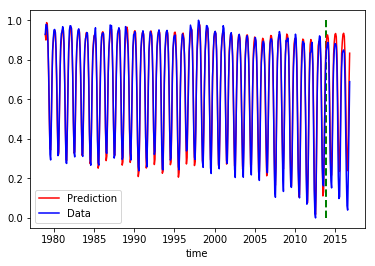

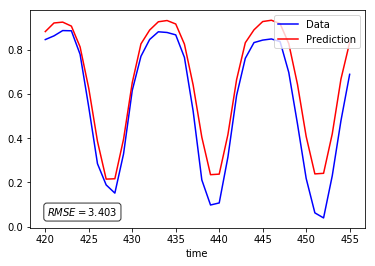

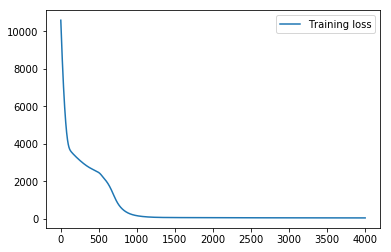

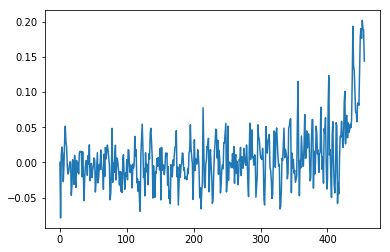

In [14]:
    # visualization
    index_plot = np.arange(len(SIC_ERAI_sum_norm))
    year_index = np.arange(1980,2017,5)
    # repeat climatology as reference
    climatology = np.tile(seansonal_cycle_SIC,len(SIC_ERAI_sum_norm)//12)
    # create index
    fig1 = plt.figure()
    plt.vlines(index_plot[-test_year*12],0,1,colors='g',linestyle='dashed',linewidth=2)
    plt.plot(index_plot, data_predict, 'r',label="Prediction")
    plt.plot(index_plot, SIC_ERAI_sum_norm, 'b',label="Data")
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Data")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Training")
    plt.xlabel('time')
    plt.xticks(np.arange(13,len(index_plot)+1,60),year_index)
    plt.legend()
    plt.show()
    fig1.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_full.png'),dpi=300)
    
    # include text box in the figure
    text_content = '$RMSE=%.3f$ ' % (error_pred)
    fig0 = plt.figure()
    plt.plot(index_plot[-test_year*12:], SIC_ERAI_sum_norm[-test_year*12:], 'b',label="Data")
    plt.plot(index_plot[-test_year*12:], data_predict[-test_year*12:], 'r',label="Prediction")
    #plt.plot(index_plot, climatology, 'c--',label="climatology")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Data")
    #plt.plot(y_train[:,0,0].detach().numpy(), label="Training")
    plt.xlabel('time')
    #plt.xticks(np.arange(384,len(index_plot)+1,60),year_index)
    plt.legend(loc=1)
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax = plt.gca()
    ax.text(0.05,0.1,text_content,transform=ax.transAxes,fontsize=10,verticalalignment='top',bbox=props)
    plt.show()
    fig0.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred.png'),dpi=300)    
    
    fig2 = plt.figure()
    plt.plot(hist[:], label="Training loss")
    plt.legend()
    plt.show()
    fig2.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_error.png'),dpi=300)
    
    plt.plot(data_predict-SIC_ERAI_sum_norm)

In [ ]:
#     print ('*******************  run linear regression  *********************')
#     model = LinearReg()
#     # construct loss function and an optimizer.
#     criterion = torch.nn.MSELoss(size_average=False)
#     optimizer = torch.optim.SGD(model.parameters(),lr=0.01) # learning rate (lr)
#     #####################
#     # Train Loop
#     #####################
#     for epoch in range(num_epoch):
#         # predict y by fit x through linear regression
#         y_predict = model(SIV_var)
#         # compute and print loss
#         loss = criterion(y_predict,y_train)
        
#         # backpropagation and gradient descend (fix steps)
#         # Zero out gradient, else they will accumulate between epochs
#         optimizer.zero_grad()
    
#         # Backward pass
#         loss.backward()

#         # Update parameters
#         optimizer.step()        